# INSIGHTS

As anotações e documentação dos testes estão no Maxtrade


#### Bibliotecas

In [1]:
# BASIC
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import joblib

# CLASSIFIER
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

#REGRESSOR
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

# PRE-PROCESSING
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

#METRICS
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

# STATISTIC
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#INDICATORS
import pandas_ta as ta

# DATA VIZ
import matplotlib.pyplot as plt
import seaborn as sns

# WARNING
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
# APPL HORA EXEMPLO DO ANDRE KUNIYOSHI
colunas = ['Time', 'Open', 'High', 'Low', 'Close','Adj Close','Volume']
df_base = pd.read_csv(r'C:\_PY\Trade_NB\_DS\Bases\df_AAPL_hora.csv')
df_base.columns = colunas
df_base['Time'] = pd.to_datetime(df_base['Time'], utc=True)
df_base.set_index('Time', inplace=True)

df_base = df_base[['Open', 'High', 'Low', 'Close','Adj Close','Volume']]

# conferindo o tamanho do dataset
print('AAPL tamanho:', df_base.shape)

AAPL tamanho: (2273, 6)


### OUTLIERS

### Serie Estacionaria

In [3]:
# Agora, vamos analisar se a série é estacionária, ou não. Para que seja, ela precisa ter a média e a variância constantes no tempo, além de ter correlação entre 2 períodos constante

# Vamos utilizar o teste de Dickey Fuller para verificar se nossa série é estacionária ou não.
# H0 -> Série não estacionária (p-value > 0.05)
# H1 -> Série estacionária (p-value <= 0.05)

# o resultado estatístico mostrou que a série não é estacionária. (p-value > 0.05)
#Então, vamos utilizar a técnica de diferenciação para tornar a série estacionária, para podermos aplicar o modelo ARIMA

adfuller_aapl_hora = adfuller(df_base['Adj Close'])
print('ADF Statistics:', adfuller_aapl_hora[0])
print('p-value :', adfuller_aapl_hora[1])

ADF Statistics: -1.237289366571211
p-value : 0.6573526804673975


In [4]:
# Calculo do retorno percentual (1º diferenciação)
df_arima = df_base.copy()
df_arima['return_percent'] = df_arima['Adj Close'].pct_change()
df_arima.dropna(inplace=True)

In [5]:
# apenas checagem

# rodando o método de Dickey Fuller para retorno PERCENTUAL
adfuller_df_arima = adfuller(df_arima['return_percent'])
print('ADF Statistics AAPL HORA:', adfuller_df_arima[0])
print('p-value AAPL HORA:', adfuller_df_arima[1])

ADF Statistics AAPL HORA: -8.855398205628859
p-value AAPL HORA: 1.532812259092094e-14


# APLICAÇÃO DO LOG

In [6]:
# TIMEFRAME
#BASE MINUTOS DIARIO 510 
#BASE HORAS POR PREGAO DIARIO: 7
#BASE MESES PREGAO ANO: 12

time_frame = 7

# https://maxwellpaparelli.medium.com/time-series-s%C3%A9ries-temporais-com-python-f4e74fd45b0b
df_log = np.log(df_base)
ma_log = df_log.rolling(time_frame).mean()

#subtrair média do log dos dados, iremos fazer a média em 12, pois iremos fazer anualmente
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(time_frame).mean()
#desvio padrão
std_sub = df_sub.rolling(time_frame).std()

In [7]:
# apenas checagem

adfuller_df_arima = adfuller(df_log['Adj Close'])
print('ADF Statistics AAPL HORA:', adfuller_df_arima[0])
print('p-value AAPL HORA:', adfuller_df_arima[1])

ADF Statistics AAPL HORA: -1.1891641156083415
p-value AAPL HORA: 0.6782395798917242


In [8]:
# apenas checagem

#repetir o ADF
X_sub = df_sub['Adj Close'].values

# aplicar ADF e imprimir o resultado
result_sub = adfuller(X_sub)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_sub[0]))
print('Valor-p: {:.10f}'.format(result_sub[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -8.2795
Valor-p: 0.0000000000
Valores Críticos:
	1%: -3.4333
	5%: -2.8628
	10%: -2.5675


Dickey-Fuller Aumentado
Teste Estatístico: -15.7205
Valor-p: 0.0000000000
Valores Críticos:
	1%: -3.4333
	5%: -2.8628
	10%: -2.5675


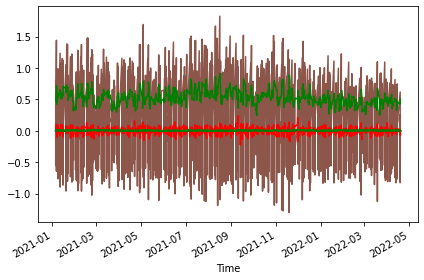

In [9]:
#Diferenciação

#aplicar diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(time_frame).mean()
#desvio padrão
std_diff = df_diff.rolling(time_frame).std()

#plotar a diferenciação
fig, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

#extrair apenas os valores e retirar os valores NA
X = df_diff['Adj Close'].dropna().values

# aplicar ADF e imprimir o resultado
result_diff = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_diff[0]))
print('Valor-p: {:.10f}'.format(result_diff[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

In [10]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2259 entries, 2021-01-04 20:30:00+00:00 to 2022-04-18 19:30:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2258 non-null   float64
 1   High       2258 non-null   float64
 2   Low        2258 non-null   float64
 3   Close      2258 non-null   float64
 4   Adj Close  2258 non-null   float64
 5   Volume     2258 non-null   float64
dtypes: float64(6)
memory usage: 123.5 KB


In [11]:
df_diff = df_diff.dropna()

In [12]:
df_diff['return_percent'] = df_diff['Adj Close'].pct_change()

### Teste de Normalidade

In [13]:
#Agora, podemos verificar se as distribuições de retorno são normais ou não.

#Para isso, vamos utilizar o método de shapiro, da lib scipy stats
print('Dataset HORAS, retorno PERCENTUAL (1º dif.):', stats.shapiro(df_diff['return_percent']))

Dataset HORAS, retorno PERCENTUAL (1º dif.): ShapiroResult(statistic=nan, pvalue=1.0)


In [14]:
m_df = df_diff.copy()

# FIM DA APLICAÇÃO DO LOG

### Variaveis Vinny

In [46]:
#-----------------------------------FEATURE ENGINEERING--------------------------------------------

In [15]:
# CRIANDO FEATURE RSI
def criar_rsi(df):
    n = 20
    def rma(x, n, y0):
        a = (n-1) / n
        ak = a**np.arange(len(x)-1, -1, -1)
        return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]

    df['change'] = df['Adj Close'].diff()
    df['gain'] = df.change.mask(df.change < 0, 0.0)
    df['loss'] = -df.change.mask(df.change > 0, -0.0)
    df['avg_gain'] = rma(df.gain[n+1:].to_numpy(), n, np.nansum(df.gain.to_numpy()[:n+1])/n)
    df['avg_loss'] = rma(df.loss[n+1:].to_numpy(), n, np.nansum(df.loss.to_numpy()[:n+1])/n)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1 + df.rs))
    return df

In [16]:
# CRIANDO FEATURE BOLLINGER BAND
def criar_bollinger(df):
  # calculando a média móvel e limites superior e inferiror
  # limites com base em 2 desvios padrão
  mid = df['Adj Close'].rolling(20).mean()
  std = df['Adj Close'].rolling(20).std()
  up = mid + std
  low = mid - std

  # criando features para a média e os limites
  df['upper'] = up
  df['mid'] = mid
  df['low'] = low
  df['bbp'] = (df['Adj Close'] - df['low'])/(df['upper'] - df['low'])
  df.dropna(inplace=True)
  return df

In [17]:
# RESISTÊNCIA
def is_resistance(df,i):
  resistance = (df['High'][i] > df['High'][i-1]
                and df['High'][i] > df['High'][i+1]
                and df['High'][i+1] > df['High'][i+2]
                and df['High'][i-1] > df['High'][i-2])
  return resistance

# SUPORTE
def is_support(df,i):
  support = (df['Low'][i] < df['Low'][i-1]
             and df['Low'][i] < df['Low'][i+1]
             and df['Low'][i+1] < df['Low'][i+2]
             and df['Low'][i-1] < df['Low'][i-2])
  return support

def suporte_resistencia(df):
  # resistência verdadeiro -> 1 (vender)
  # suporte verdadeiro -> 0 (comprar)
  # outros (2)

  # criando feature com valores 2
  df['suport_resistencia'] = 2

  # definindo os valores 1 e 0
  for i in range(2, df.shape[0] - 2):
    if is_resistance(df,i):
      df['suport_resistencia'][i] = 1 # definindo 1 para resistência
    elif is_support(df,i):
      df['suport_resistencia'][i] = 0 # definindo 0 para suporte
  return df

In [18]:
# LTA E LTB
# 0.5 são classificadas como tendência de alta, menos que -0.5 são tendência de baixa
def lta_ltb(df):
  df2 = df.reset_index()
  df['corr'] = (df2['Adj Close'].rolling(20).corr(pd.Series(df2.index))).tolist()
  df.dropna(inplace=True)

  def condition(x):
      if x<=-0.5:
          return -1
      elif x>-0.5 and x<0.5:
          return 0
      else:
          return 1
  df['corr_class'] = df['corr'].apply(condition)

  return df

In [19]:
# MÉDIA MÓVEL
def media_movel(df, coluna, defasagem):
  df['media_movel'] = df[coluna].rolling(20).mean()
  return df

In [20]:
# FEATURES DE TEMPO
def feat_temporais(df):
  df['dia_semana'] = df.index.dayofweek
  df['horario'] = df.index.hour
  df['mes'] = df.index.month
  return df

In [21]:
# CRIANDO A TARGET
def target(df):

  # criando feature com 1h de defasagem (com hora anterior)
  df['def_1'] = df['Adj Close'].shift(1)
  # criando feature comparando valor atual com o defasado
  df['subt'] = df['Adj Close'] - df['def_1']
#  criando a target de subida ou descida do valor da ação
#  0 -> caiu (com relação ao anterior)
#  1 -> subiu (com relação ao anterior)
#  2 -> igual ao anterior
  
  df['target'] = df['subt'].apply(lambda x: int(0) if x<0 else int(1) if x>0 else int(2))
  #df['target'] = df['subt'].apply(lambda x: int(0) if x<=0 else int(1))
  return df


In [22]:
# FEATURES DEFASADAS 
def constroi_features_defasadas(df,lista_features,defasagem_maxima):
    # Constrói features defasadas com base na base original
    # Copia a base
    df_cop = df.copy()
    for feat in lista_features:       
        for i in range(1,defasagem_maxima+1):
            df_cop[str(feat)+'_def_'+str(i)] = df_cop[feat].shift(i)
    
    df_cop.dropna(inplace=True)
    return df_cop

In [23]:
# FEATURES FUTURAS
def constroi_features_futuras(df,feature,defasagem):
    # Constrói features defasadas com base na base original
    # Copia a base
    df_cop = df.copy()

    df_cop[str(feature)+'_fut'] = df_cop[feature].shift(-defasagem)
    return df_cop

In [24]:
m_df = criar_rsi(m_df) # 'change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi'
m_df = criar_bollinger(m_df) #'upper', 'mid', 'low','bbp'
m_df = suporte_resistencia(m_df) #'suport_resistencia'
m_df = lta_ltb(m_df) # 'corr', 'corr_class'
m_df = media_movel(m_df, 'Adj Close', 20) # 'media_movel'
m_df = feat_temporais(m_df) # 'dia_semana', 'horario', 'mes'

In [25]:
###-----------------------------------FUNÇÃO DO MODELO-------------------------------------------- '''

In [26]:
def modelo(df, target_):
    X_test = df.drop(target_, axis=1)[-1:]

    X_train = df[:-1].dropna().drop(target_, axis=1)
    y_train = df[:-1].dropna()[target_]

    xgb = XGBClassifier(random_state=42,
			gamma = 0.1,
			max_depth = 8,
			n_estimators = 100,
			n_jobs=-1)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    y_proba = xgb.predict_proba(X_test)
    y_proba = y_proba[:, 1]
    return y_pred, y_proba

In [27]:
def preprocessamento(base, corte_treino_teste,target):
  # separando a base da target
  X = base.drop(target, axis=1)
  y = base[target]
  # cortando em treino e teste
  X_train = X[X.index<=corte_treino_teste]
  X_test = X[X.index>corte_treino_teste]
  y_train = y[y.index<=corte_treino_teste]
  y_test = y[y.index>corte_treino_teste]
  return X_train, X_test, y_train, y_test

In [28]:
modelos_candidatos = {'Árvore':DecisionTreeClassifier(random_state=42),
                      'RandomForest':RandomForestClassifier(random_state=42),
                      'XGBoost':XGBClassifier(random_state=42)
                     }
def avaliacao_modelos(modelos,X_train,y_train):
  avaliacao = {}
  scores = []
  ts = TimeSeriesSplit(n_splits=5).split(X_train,y_train)
  for nome,model in modelos_candidatos.items():
    # Avalia a crossvalidação
    score = cross_val_score(model, # Escolhendo o nosso modelo da vez
                          X_train, y_train, # Nossos dados, excluindo o teste
                          cv=TimeSeriesSplit(n_splits=5).split(X_train,y_train), # Validação cruzada temporal
                          scoring='accuracy', # Usando a acurácia como métrica
                          ).mean() # Tirando a média de todos os folds
    avaliacao[nome] = score
    scores.append(score)
  
  return avaliacao, scores

In [29]:
##-----------------------------------CRIANDO DATASET-------------------------------------------- '''
hora_previsao = 1
m_df = target(m_df)
m_df.dropna(inplace=True) #, 'bbp', 'corr_class'
#m_df = m_df[['bbp', 'corr_class','amplitude','body','pavil_call', 'pavil_put', 'retorno_volume', 'retorno','target', 'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
m_df = m_df[['bbp', 'corr_class','target', 'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
m_df = constroi_features_defasadas(m_df,['Adj Close'],20)
m_df = constroi_features_futuras(m_df,'target',hora_previsao)
m_df_model = m_df.drop('target', axis=1)

### Normalização

In [30]:
#scaler = MinMaxScaler()#StandardScaler() #MinMaxScaler()
scaler = StandardScaler() #MaxAbsScaler()

### Treino Teste

In [31]:
m_df = m_df.dropna()

##### tradicional

##### exemplo do Mario

##### exemplo do Andre

In [32]:
m_df = m_df.loc[:,['bbp','corr_class', 'target', 
        'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana',
       'horario', 'mes', 'Adj Close_def_1', 'Adj Close_def_2',
       'Adj Close_def_3', 'Adj Close_def_4', 'Adj Close_def_5',
       'Adj Close_def_6', 'Adj Close_def_7', 'Adj Close_def_8',
       'Adj Close_def_9', 'Adj Close_def_10', 'Adj Close_def_11',
       'Adj Close_def_12', 'Adj Close_def_13', 'Adj Close_def_14',
       'Adj Close_def_15', 'Adj Close_def_16', 'Adj Close_def_17',
       'Adj Close_def_18', 'Adj Close_def_19', 'Adj Close_def_20','target_fut']]

In [33]:
x_train, x_test, y_train, y_test = preprocessamento(m_df, m_df.index[round(len(m_df.index) * 0.8)], 'target_fut')

x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

##### MODELOS CANDIDATOS - ANDRÉ

In [34]:
avaliacao_modelos(modelos_candidatos, x_train, y_train)

({'Árvore': 0.6586206896551724,
  'RandomForest': 0.7510344827586206,
  'XGBoost': 0.7434482758620689},
 [0.6586206896551724, 0.7510344827586206, 0.7434482758620689])

### MEUS MODELOS

### naive bayes

In [144]:
modelo = GaussianNB()
modelo.fit(x_train, y_train)
previsoes = modelo.predict(x_test)
print('\nClassification Report\n', metrics.classification_report(y_test, previsoes))
#Precision_0 = nb['0.0']['precision']
nb = metrics.classification_report(y_test, previsoes, output_dict=True)
nb_roc = roc_auc_score(y_test, previsoes)


Classification Report
               precision    recall  f1-score   support

         0.0       0.75      0.81      0.78       177
         1.0       0.77      0.71      0.74       160

    accuracy                           0.76       337
   macro avg       0.76      0.76      0.76       337
weighted avg       0.76      0.76      0.76       337



### Logistic Regression

In [130]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

lr_y_pred = pd.Series(classifier.predict(x_test))
lr_y_test = y_test.reset_index(drop=True)

#print('\nClassification Report\n', metrics.classification_report(lr_y_test, lr_y_pred)) 
lr = metrics.classification_report(lr_y_test, lr_y_pred, output_dict=True)
lr_roc = roc_auc_score(lr_y_test, lr_y_pred)


Classification Report
               precision    recall  f1-score   support

         0.0       0.79      0.75      0.77       177
         1.0       0.73      0.78      0.75       160

    accuracy                           0.76       337
   macro avg       0.76      0.76      0.76       337
weighted avg       0.76      0.76      0.76       337



### Random Forest Classifiers

In [141]:
# importar o modelo Random Forest Classifier

# treinando o modelo 
classifier = RandomForestClassifier(n_estimators= 21, random_state=42).fit(x_train, y_train);

# aplicando o modelo treinado para a previsão do resultado do teste
predictions3_labels = classifier.predict(x_test)

# Exibindo dataframe com valores 10 reais e suas respectivas previsões
#p = pd.DataFrame({'Real': y_test, 'Previsto': predictions3_labels})  

print('\nClassification Report\n', metrics.classification_report(y_test, predictions3_labels)) 
rfc = metrics.classification_report(y_test, predictions3_labels, output_dict=True)
rfc_roc = roc_auc_score(y_test, predictions3_labels)
rfc_roc


Classification Report
               precision    recall  f1-score   support

         0.0       0.75      0.76      0.75       177
         1.0       0.73      0.72      0.73       160

    accuracy                           0.74       337
   macro avg       0.74      0.74      0.74       337
weighted avg       0.74      0.74      0.74       337



0.7410310734463277

### XGBOOST

In [142]:
# fitando o modelo
xgb = XGBClassifier(random_state=42,max_depth=5) 
#xgb = XGBClassifier(random_state=42, gamma = 0.75, max_depth=2, n_estimators=50)
xgb.fit(x_train, y_train)
y1_pred = xgb.predict(x_test)
print('\nClassification Report\n', metrics.classification_report(y_test, y1_pred)) 

xgb_c = metrics.classification_report(y_test, y1_pred, output_dict=True)
xgb_c_roc = roc_auc_score(y_test, y1_pred)
xgb_c_roc


Classification Report
               precision    recall  f1-score   support

         0.0       0.76      0.75      0.75       177
         1.0       0.73      0.74      0.73       160

    accuracy                           0.74       337
   macro avg       0.74      0.74      0.74       337
weighted avg       0.75      0.74      0.74       337



0.7447563559322034

### LGBM

In [35]:
train_data=lgb.Dataset(x_train,label=y_train)

#setting parameters for lightgbm
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

#Here we have set max_depth in xgb and LightGBM to 7 to have a fair comparison between the two.

#training our model using light gbm
num_round=50
start=datetime.now()
lgbm=lgb.train(param,train_data,num_round)
stop=datetime.now()

#Execution time of the model
execution_time_lgbm = stop-start
execution_time_lgbm

#predicting on test set
ypred2=lgbm.predict(x_test)
ypred2[0:5]  # showing first 5 predictions

#converting probabilities into 0 or 1

for i in range(0,len(ypred2)):
    if ypred2[i]>=.5:       # setting threshold to .5
       ypred2[i]=1
    else:  
       ypred2[i]=0
#calculating accuracy

accuracy_lgbm = accuracy_score(ypred2,y_test)
y_test.value_counts()


#auc_lgbm, accuracy_lgbm

print('\nClassification Report\n', metrics.classification_report(y_test, ypred2)) 
lgbmc = metrics.classification_report(y_test, ypred2, output_dict=True)
auc_lgbmc = roc_auc_score(y_test,ypred2)


[LightGBM] [Info] Number of positive: 867, number of negative: 877
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5035
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497133 -> initscore=-0.011468
[LightGBM] [Info] Start training from score -0.011468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

# LGBM 2

In [37]:
from lightgbm import LGBMClassifier
?LGBMClassifier

In [48]:
# implementação simples sugerida pelo Mario F
# Nunca Mais Use Grid Search Para Ajustar Hiperparâmetros - 
# baysian optimization - urhttps://www.youtube.com/watch?v=WhnkeasZNHI
from lightgbm import LGBMClassifier

mdl = LGBMClassifier(random_state=0)
mdl.fit(x_train, y_train)

from sklearn.metrics import roc_auc_score
p = mdl.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, p)



0.8134994500380743

In [49]:
print('\nClassification Report\n', metrics.classification_report(y_test, p2)) 
p2 = mdl.predict(x_test) # para ter 


Classification Report
               precision    recall  f1-score   support

         0.0       0.74      0.72      0.73       223
         1.0       0.71      0.73      0.72       212

    accuracy                           0.72       435
   macro avg       0.72      0.72      0.72       435
weighted avg       0.72      0.72      0.72       435



##### RANDOM SEARCH

In [52]:
# pip install scikit-optimize
from skopt import dummy_minimize

In [53]:
def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    mdl = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100)
    mdl.fit(x_train, y_train)
    
    p = mdl.predict_proba(x_test)[:,1]
    
    return -roc_auc_score(y_test, p)

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

resultado = dummy_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3717
Function value obtained: -0.8064
Current minimum: -0.8064
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0937
Function value obtained: -0.8102
Current minimum: -0.8102
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3212
Function value obtained: -0.8239
Current minimum: -0.8239
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895] 

Iteration No: 4 ended. Evaluation done at random point.
Time

In [54]:
resultado.x

[0.011327034010293172, 103, 14, 0.3894062720023748, 0.9176816358278194]

In [57]:
resultado.fun

-0.8276503934343008

##### Bayesian Optimization

In [59]:
from skopt import gp_minimize

In [60]:
resultados_gp = gp_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 120, 14, 0.9990884895579377, 0.3124800792567785] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7548
Function value obtained: -0.8068
Current minimum: -0.8068
Iteration No: 2 started. Evaluating function at random point.
[0.006210998932353835, 51, 67, 0.9387621172657304, 0.8616798250174156] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1719
Function value obtained: -0.8173
Current minimum: -0.8173
Iteration No: 3 started. Evaluating function at random point.
[0.004232013397179603, 68, 45, 0.2680983530433343, 0.5809725180523154] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1141
Function value obtained: -0.8126
Current minimum: -0.8173
Iteration No: 4 started. Evaluating function at random point.
[0.0672858974212934, 60, 44, 0.9421713999524447, 0.8005503127028804] 

Iteration No: 4 ended. Evaluation done at random point.
Time ta

In [61]:
resultados_gp.x

[0.028257151606232735, 127, 31, 0.55862504034686, 0.5966992543102516]

In [62]:
resultados_gp.fun

-0.8283061172688045

#### LGBM WITH TUNNING 

In [64]:
mdl_2 = LGBMClassifier(learning_rate = 0.028257,
    num_leaves = 127,
    min_child_samples = 31,
    subsample = 0.558625,
    colsample_bytree = 0.596699)

mdl_2.fit(x_train, y_train)

p_2 = mdl_2.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, p_2)

0.8287503172857265

In [65]:
p_3 = mdl_2.predict(x_test) # para ter
print('\nClassification Report\n', metrics.classification_report(y_test, p_3)) 



Classification Report
               precision    recall  f1-score   support

         0.0       0.74      0.76      0.75       223
         1.0       0.74      0.73      0.73       212

    accuracy                           0.74       435
   macro avg       0.74      0.74      0.74       435
weighted avg       0.74      0.74      0.74       435



In [66]:
from skopt.plots import plot_convergence

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

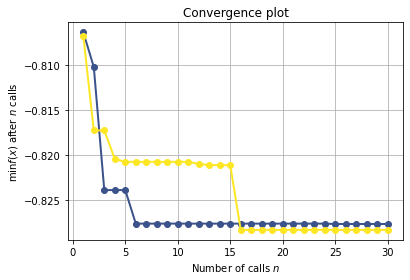

In [67]:
plot_convergence(resultado, resultados_gp)

### Support Vector Machine SVM

In [152]:
#importar o modelo SVM


# instanciacao e determinacao dos hiperparâmetros do SVM: tipo de kernel
classifier = SVC(kernel='rbf')

# treinando o SVM
classifier.fit(x_train, y_train)

# aplicando o modelo treinado para a previsão da temperatura 
#em todo o conjunto de teste
predictions2_labels = classifier.predict(x_test)

# Exibindo dataframe com valores 10 reais e suas respectivas previsões
p = pd.DataFrame({'Real': y_test, 'Previsto': predictions2_labels})  

print('\nClassification Report\n', metrics.classification_report(y_test, predictions2_labels)) 
svm_c = metrics.classification_report(y_test, predictions2_labels, output_dict=True)
svm_c_roc = roc_auc_score(y_test, predictions2_labels)


Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.77      0.77       177
         1.0       0.75      0.75      0.75       160

    accuracy                           0.76       337
   macro avg       0.76      0.76      0.76       337
weighted avg       0.76      0.76      0.76       337



### ENSAMBLE CLASSIFIER

In [154]:
# Caso não tenha efetuado a normalização/padronização anteriormente
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(x_train)
#X_scaled_test = scaler.transform(x_test)

X_scaled = (x_train)
X_scaled_test = (x_test)

model_sgd = SGDClassifier()
model_svc = SVC()
model_dt = DecisionTreeClassifier()

#SEED = 42
#np.random.seed(SEED)

predict = pd.DataFrame(y_test)
for model in (model_sgd, model_svc, model_dt):
  model.fit(X_scaled, y_train)
  y_pred = model.predict(X_scaled_test)
  predict[model.__class__.__name__] = y_pred

predict

target_fut  SGDClassifier  SVC  DecisionTreeClassifier
0           1.0            1.0  1.0                     1.0
1           0.0            0.0  0.0                     0.0
2           0.0            0.0  0.0                     0.0
3           0.0            1.0  1.0                     1.0
4           1.0            1.0  1.0                     0.0
..          ...            ...  ...                     ...
332         1.0            1.0  1.0                     1.0
333         1.0            0.0  0.0                     0.0
334         0.0            1.0  0.0                     0.0
335         1.0            1.0  0.0                     0.0
336         0.0            1.0  0.0                     1.0

[337 rows x 4 columns]

In [155]:
# utilizando o classificador de votação
#from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators = [('sgd', model_sgd),('svc', model_svc),('dt', model_dt)]
)

predict2 = pd.DataFrame(y_test)
for model in (model_sgd, model_svc, model_dt, voting_clf):
  model.fit(X_scaled, y_train)
  y_pred = model.predict(X_scaled_test)
  predict2[model.__class__.__name__] = y_pred

predict2

target_fut  SGDClassifier  SVC  DecisionTreeClassifier  VotingClassifier
0           1.0            1.0  1.0                     0.0               1.0
1           0.0            0.0  0.0                     1.0               0.0
2           0.0            0.0  0.0                     0.0               0.0
3           0.0            0.0  1.0                     1.0               1.0
4           1.0            1.0  1.0                     1.0               1.0
..          ...            ...  ...                     ...               ...
332         1.0            1.0  1.0                     1.0               1.0
333         1.0            0.0  0.0                     1.0               0.0
334         0.0            0.0  0.0                     0.0               0.0
335         1.0            1.0  0.0                     0.0               0.0
336         0.0            0.0  0.0                     1.0               0.0

[337 rows x 5 columns]

In [157]:
# obtendo as acurácias
model = []
accuracy = []
for clf in (model_sgd, model_svc, model_dt, voting_clf):
  clf.fit(X_scaled, y_train)
  voting_y_pred = clf.predict(X_scaled_test)
  model.append(clf.__class__.__name__)
  accuracy.append(accuracy_score(y_test,voting_y_pred))

col = ['Acurácia']
ac = pd.DataFrame(data=accuracy, index = model,columns=col)
ac

Acurácia
SGDClassifier           0.727003
SVC                     0.762611
DecisionTreeClassifier  0.670623
VotingClassifier        0.738872

In [158]:
print('\nClassification Report\n', metrics.classification_report(y_test,voting_y_pred)) 
voting_c = metrics.classification_report(y_test,voting_y_pred, output_dict=True)
voting_c_roc = roc_auc_score(y_test,voting_y_pred)


Classification Report
               precision    recall  f1-score   support

         0.0       0.81      0.66      0.72       177
         1.0       0.69      0.83      0.75       160

    accuracy                           0.74       337
   macro avg       0.75      0.74      0.74       337
weighted avg       0.75      0.74      0.74       337



#### COMPARAÇÃO DE RESULTADOS

In [159]:
#exemplo para compilar os resultados para uma análise posterior
table = pd.DataFrame(data={
    'scores': ['Accuracy', 'F1 Score 0', 'F1 Score 1', 'Precision 0', 'Precision 1', 'Recall 0', 'Recall 1', 'AUC'],
    
    'Naive Bayes': [round(nb['accuracy'],2), 
                    round(nb['0.0']['f1-score'],2), 
                    round(nb['1.0']['f1-score'],2), 
                    round(nb['0.0']['precision'],2), 
                    round(nb['1.0']['precision'],2), 
                    round(nb['0.0']['recall'],2), 
                    round(nb['1.0']['recall'],2), 
                    round(nb_roc,2)],
    
    'Logistic Regression': [round(lr['accuracy'],2), 
                    round(lr['0.0']['f1-score'],2), 
                    round(lr['1.0']['f1-score'],2), 
                    round(lr['0.0']['precision'],2), 
                    round(lr['1.0']['precision'],2), 
                    round(lr['0.0']['recall'],2), 
                    round(lr['1.0']['recall'],2), 
                    round(lr_roc,2)],
    
    'SVM': [round(svm_c['accuracy'],2), 
                    round(svm_c['0.0']['f1-score'],2), 
                    round(svm_c['1.0']['f1-score'],2), 
                    round(svm_c['0.0']['precision'],2), 
                    round(svm_c['1.0']['precision'],2), 
                    round(svm_c['0.0']['recall'],2), 
                    round(svm_c['1.0']['recall'],2), 
                    round(svm_c_roc,2)],
    
    'Random Forest': [round(rfc['accuracy'],2), 
                    round(rfc['0.0']['f1-score'],2), 
                    round(rfc['1.0']['f1-score'],2), 
                    round(rfc['0.0']['precision'],2), 
                    round(rfc['1.0']['precision'],2), 
                    round(rfc['0.0']['recall'],2), 
                    round(rfc['1.0']['recall'],2), 
                    round(rfc_roc,2)],
   
    'XGBoost':  [round(xgb_c['accuracy'],2), 
                    round(xgb_c['0.0']['f1-score'],2), 
                    round(xgb_c['1.0']['f1-score'],2), 
                    round(xgb_c['0.0']['precision'],2), 
                    round(xgb_c['1.0']['precision'],2), 
                    round(xgb_c['0.0']['recall'],2), 
                    round(xgb_c['1.0']['recall'],2), 
                    round(xgb_c_roc,2)],
    
    'LGBM':  [round(lgbmc['accuracy'],2), 
                    round(lgbmc['0.0']['f1-score'],2), 
                    round(lgbmc['1.0']['f1-score'],2), 
                    round(lgbmc['0.0']['precision'],2), 
                    round(lgbmc['1.0']['precision'],2), 
                    round(lgbmc['0.0']['recall'],2), 
                    round(lgbmc['1.0']['recall'],2), 
                    round(auc_lgbmc,2)],
    
        'Voting Classifier':  [round(voting_c['accuracy'],2), 
                    round(voting_c['0.0']['f1-score'],2), 
                    round(voting_c['1.0']['f1-score'],2), 
                    round(voting_c['0.0']['precision'],2), 
                    round(voting_c['1.0']['precision'],2), 
                    round(voting_c['0.0']['recall'],2), 
                    round(voting_c['1.0']['recall'],2), 
                    round(voting_c_roc,2)]
})

table.index = table['scores']
table.drop('scores', axis=1, inplace=True)

table
     

Naive Bayes  Logistic Regression   SVM  Random Forest  XGBoost  \
scores                                                                        
Accuracy            0.76                 0.76  0.76           0.74     0.74   
F1 Score 0          0.78                 0.77  0.77           0.75     0.75   
F1 Score 1          0.74                 0.75  0.75           0.73     0.73   
Precision 0         0.75                 0.79  0.77           0.75     0.76   
Precision 1         0.77                 0.73  0.75           0.73     0.73   
Recall 0            0.81                 0.75  0.77           0.76     0.75   
Recall 1            0.71                 0.78  0.75           0.72     0.74   
AUC                 0.76                 0.76  0.76           0.74     0.74   

             LGBM  Voting Classifier  
scores                                
Accuracy     0.75               0.74  
F1 Score 0   0.76               0.72  
F1 Score 1   0.75               0.75  
Precision 0  0.79               0.81  
Precision 1  0.72               0.69  
Recall 0     0.73               0.66  
Recall 1     0.78               0.83  
AUC          0.76               0.74

# REGRESSAO

In [65]:
rx_train, rx_test, ry_train, ry_test = preprocessamento(m_df.iloc[:,:-1], m_df.index[round(len(m_df.index) * 0.8)], 'Adj Close')
rx_train = scaler.fit_transform(rx_train)
rx_test  = scaler.transform(rx_test)

In [66]:
#treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(rx_train, ry_train)
pred= lr.predict(rx_test)
cd =r2_score(ry_test, pred)

f'Coeficiente de determinação (R2):{cd * 100:.2f}'


'Coeficiente de determinação (R2):100.00'

In [67]:
# instanciando o modelo Support Vector Regression
svr = SVR()

# treinando o modelo
svr.fit(rx_train, ry_train)

# prevendo os valores
y_predict = svr.predict(rx_test)
cd_svr = r2_score(ry_test, y_predict)

f'Coeficiente de determinação (R2):{cd_svr * 100:.2f}'


'Coeficiente de determinação (R2):-0.55'

In [68]:
# instanciando o modelo Random Forest Regressor
rfr = RandomForestRegressor(n_estimators= 20, random_state=42).fit(rx_train, ry_train); #n_estimators= 10, random_state=42
pred = rfr.predict(rx_test)
cd_RL = r2_score(ry_test, pred)

f'Coeficiente de determinação (R2):{cd_RL * 100:.2f}'


'Coeficiente de determinação (R2):89.69'

In [69]:
# instanciando o modelo XGBoost Regressor


xgbr = XGBRegressor()
xgbr.fit(rx_train, ry_train)
pred = xgbr.predict(rx_test)

cd_XGBR = r2_score(ry_test, pred)

f'Coeficiente de determinação (R2):{cd_XGBR * 100:.2f}'


'Coeficiente de determinação (R2):75.21'

In [71]:
pred

array([-6.7896319e-05,  2.9738450e-05,  2.9738450e-05,  2.9738450e-05,
       -1.3521499e-05,  7.1513408e-05,  2.9738450e-05, -1.3521499e-05,
       -1.0153050e-04, -1.3521499e-05, -3.2212494e-05,  2.9738450e-05,
       -6.7896319e-05, -1.3521499e-05,  7.1513408e-05, -1.3521499e-05,
       -3.2212494e-05, -1.0153050e-04, -3.2212494e-05,  2.9738450e-05,
       -1.3521499e-05,  1.1370414e-04,  1.1370414e-04,  2.9738450e-05,
       -6.7896319e-05,  2.9738450e-05, -1.0153050e-04, -1.3521499e-05,
       -6.7896319e-05, -1.0153050e-04,  2.9738450e-05, -1.3521499e-05,
        2.9738450e-05, -3.2212494e-05,  2.9738450e-05,  1.1370414e-04,
        2.9738450e-05,  2.9738450e-05, -1.3521499e-05, -3.2212494e-05,
       -1.0153050e-04,  2.9738450e-05,  2.9738450e-05, -1.3521499e-05,
        7.1513408e-05, -3.2212494e-05,  7.1513408e-05, -6.7896319e-05,
       -1.0153050e-04,  7.1513408e-05, -1.3521499e-05,  7.1513408e-05,
        1.1370414e-04,  2.9738450e-05,  2.9738450e-05, -6.7896319e-05,
      

### ENSEMBLE REGRESSOR

In [53]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [54]:
X_scaled = (rx_train)
X_scaled_test = (rx_test)

In [55]:
# Training regressors
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 =  XGBRegressor(random_state=1) #LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('xbr', reg3)])
ereg = ereg.fit(rx_train, ry_train)

In [56]:
predict2 = pd.DataFrame(ry_test)
for model in (reg1, reg2, reg3, ereg):
  model.fit(X_scaled, ry_train)
  ry_pred = model.predict(X_scaled_test)
  predict2[model.__class__.__name__] = ry_pred

predict2

Adj Close  GradientBoostingRegressor  \
Time                                                              
2022-01-18 19:30:00+00:00   0.002853                   0.003511   
2022-01-18 20:30:00+00:00  -0.000299                  -0.000519   
2022-01-19 14:30:00+00:00   0.002273                   0.002763   
2022-01-19 15:30:00+00:00  -0.010024                  -0.012268   
2022-01-19 16:30:00+00:00   0.008291                   0.008362   
...                              ...                        ...   
2022-04-18 14:30:00+00:00  -0.006083                  -0.004727   
2022-04-18 15:30:00+00:00  -0.002585                  -0.002127   
2022-04-18 16:30:00+00:00   0.006372                   0.005222   
2022-04-18 17:30:00+00:00   0.006881                   0.005802   
2022-04-18 18:30:00+00:00  -0.003033                  -0.002297   

                           RandomForestRegressor  XGBRegressor  \
Time                                                             
2022-01-18 19:30:00+00:00               0.003488      0.002876   
2022-01-18 20:30:00+00:00              -0.000481     -0.000425   
2022-01-19 14:30:00+00:00               0.002730      0.002415   
2022-01-19 15:30:00+00:00              -0.012756     -0.014169   
2022-01-19 16:30:00+00:00               0.008894      0.007275   
...                                          ...           ...   
2022-04-18 14:30:00+00:00              -0.004874     -0.003814   
2022-04-18 15:30:00+00:00              -0.002524     -0.002540   
2022-04-18 16:30:00+00:00               0.005489      0.005640   
2022-04-18 17:30:00+00:00               0.006366      0.006087   
2022-04-18 18:30:00+00:00              -0.002503     -0.002141   

                           VotingRegressor  
Time                                        
2022-01-18 19:30:00+00:00         0.003292  
2022-01-18 20:30:00+00:00        -0.000475  
2022-01-19 14:30:00+00:00         0.002636  
2022-01-19 15:30:00+00:00        -0.013065  
2022-01-19 16:30:00+00:00         0.008177  
...                                    ...  
2022-04-18 14:30:00+00:00        -0.004472  
2022-04-18 15:30:00+00:00        -0.002397  
2022-04-18 16:30:00+00:00         0.005450  
2022-04-18 17:30:00+00:00         0.006085  
2022-04-18 18:30:00+00:00        -0.002314  

[435 rows x 5 columns]

In [57]:
# obtendo as métricas R2
model = []
r2 = []
for clf in (reg1, reg2, reg3, ereg):
  clf.fit(X_scaled, ry_train)
  ry_pred = clf.predict(X_scaled_test)
  model.append(clf.__class__.__name__)
  r2.append(r2_score(ry_test, ry_pred))

col = ['R2']
ac = pd.DataFrame(data=r2, index = model,columns=col)
ac

R2
GradientBoostingRegressor  0.923985
RandomForestRegressor      0.913595
XGBRegressor               0.924477
VotingRegressor            0.924526

## EXPORTANDO O MODELO

In [99]:
ativo = 'EURUSD'

In [100]:
path = 'C:/_PY/Trade_NB/IQOPTION/'

In [101]:
joblib.dump(xgb, path + 'model_'+ ativo +'.pkl')

['C:/_PY/Trade_NB/IQOPTION/model_EURUSD.pkl']

In [102]:
joblib.dump(xgbr, path + 'r_model_'+ ativo +'.pkl')

['C:/_PY/Trade_NB/IQOPTION/r_model_EURUSD.pkl']

## IMPORTANDO O MODELO

In [16]:
path = 'C:/_PY/Trade_NB/IQOPTION/'

In [17]:
model = joblib.load(path + 'model_'+ ativo +'.pkl')

In [18]:
r_model = joblib.load(path + 'r_model_'+ ativo +'.pkl')